In [10]:

import EFIE_solver_2D as efie
import geometry_2D as gm
import numpy as np
light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12
frequency = 1e6 * 146
omega = 2 * np.pi * frequency
incident_voltage = 10

class antenna:
    def __init__(self, position, angle, length, source_position, radius):
        self.position = position
        self.angle = angle
        self.length = length
        self.source_position = source_position
        self.radius = radius

wavelength = light_speed / frequency
delta_r = wavelength/ 5e2

n_x, n_y = 9, 3
pos, length, radii, angle, source = [], np.full(n_x * n_y, wavelength/2), np.full(n_x * n_y, 3.175e-3), np.full(n_x * n_y, np.pi/2), np.array([[0.0, 0.0], [0.0, 0.75*wavelength], [0.0, -0.75*wavelength]])
for i in range(n_y):
    for j in range(n_x):
        y_ij = 0.75 * wavelength * (i - int(n_y/2))
        x_ij = 0.25 * wavelength * (j - int(n_x/2))
        pos.append([x_ij, y_ij])    
pos = np.array(pos)
test = antenna(pos, angle, length, source, radii)


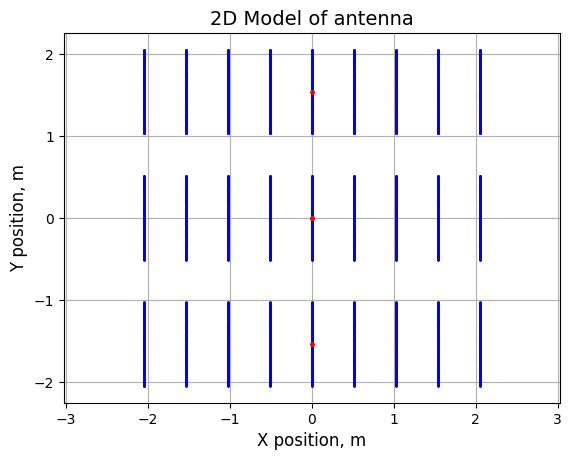

In [11]:
R_block, R = gm.calculate_positions(antenna=test, delta_r=delta_r)
gm.plot_antenna(R_block=R_block, R=R, antenna=test, delta_r=delta_r)

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [02:48<00:00,  6.24s/it]


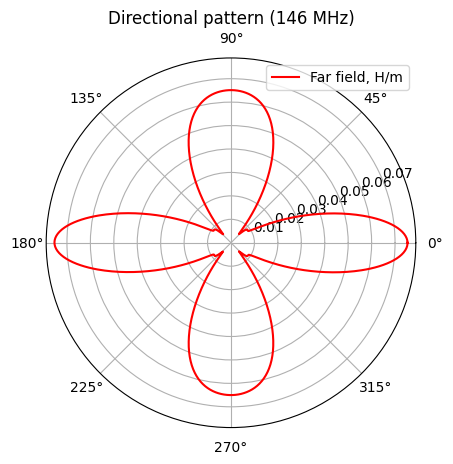

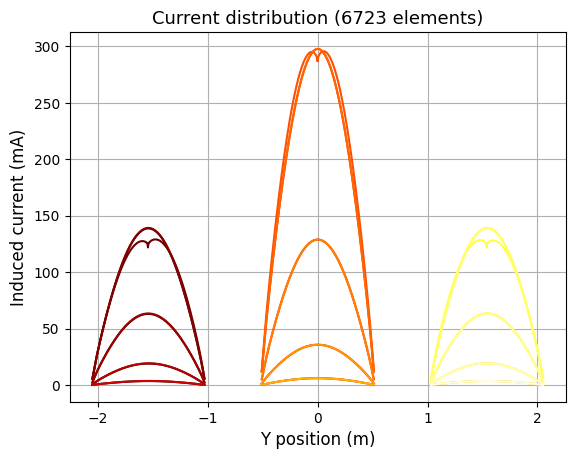

In [12]:
current = efie.calculate_currents(test, incident_voltage, frequency, delta_r)
E_total, angles = efie.directional_pattern(current=current, R=R, delta_r=delta_r, frequency=frequency)
gm.dp(E_total, angles)
gm.current_disribution_together(R_block, current)
gm.current_distribution_2d(R, current)

In [ ]:
import numpy as np
import pyswarms as ps
import geometry_2D as gm
import EFIE_solver_2D as efie
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.pyplot as plt
colors = ['green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'brown', 'gray', 'black']

class antenna:
    def __init__(self, position, angle, length, source_position, radius):
        self.position = position
        self.angle = angle
        self.length = length
        self.source_position = source_position
        self.radius = radius

light_speed, mu0, eps0, incident_field, frequency = 299792458., 4*np.pi*1e-7, 8.854e-12, 10, 1e6 * 146
omega = 2 * np.pi * frequency
radius = 3.175e-3
source_positions = np.array([[0.0, 0.0]])
delta_r = light_speed / frequency / 1e2

k_form, k_max, k_side = 1, 1, 1
E_0 = 0.5

phi = np.linspace(0, 2*np.pi, 1000)
aim_func = np.zeros(len(phi))
for i in range(len(phi)): aim_func[i] = max(0,np.sin(np.pi/2-phi[i]))**7 

def graph_to_antenna(graph, structure_type):
    center_positions, angles, lengths, radii = np.zeros((len(graph)-1,2)), np.zeros(len(graph)-1), np.zeros(len(graph)-1), np.zeros(len(graph)-1)
    source = np.array([(graph[0] + graph[1]) / 2])
    if structure_type == 'polygonal chain':
        for i in range (len(graph)-1):
            center_positions[i] = (graph[i] + graph[i+1]) / 2
            dy = graph[i+1, 1] - graph[i, 1]
            dx = graph[i+1, 0] - graph[i, 0]
            angles[i] = np.arctan2(dy, dx)
            lengths[i] = np.linalg.norm(graph[i+1] - graph[i])
            radii[i] = radius
    ans = antenna(center_positions, angles, lengths, source, radii)
    return ans
        
def check_self_intersection(points):
    def orientation(p, q, r):
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        if val == 0:
            return 0
        return 1 if val > 0 else 2
    def on_segment(p, q, r):
        return (min(p[0], r[0]) <= q[0] <= max(p[0], r[0]) and
                min(p[1], r[1]) <= q[1] <= max(p[1], r[1]))
    def segments_intersect(p1, q1, p2, q2):
        o1 = orientation(p1, q1, p2)
        o2 = orientation(p1, q1, q2)
        o3 = orientation(p2, q2, p1)
        o4 = orientation(p2, q2, q1)
        if o1 != o2 and o3 != o4:
            return True
        if o1 == 0 and on_segment(p1, p2, q1):
            return True
        if o2 == 0 and on_segment(p1, q2, q1):
            return True
        if o3 == 0 and on_segment(p2, p1, q2):
            return True
        if o4 == 0 and on_segment(p2, q1, q2):
            return True
        return False
    n = len(points)
    if n < 4:
        return False  
    for i in range(n - 1):
        for j in range(i + 2, n - 1):
            if segments_intersect(points[i], points[i+1], points[j], points[j+1]):
                return True
    return False



def fit_form (E_total):
    return np.clip(1 - np.dot(E_total/np.max(E_total),aim_func)/np.linalg.norm(aim_func)/np.linalg.norm(E_total/np.max(E_total)),0, 1e9)

def fit_max (E_total):
    return np.clip(np.exp(1 - E_total[0]/E_0) - 1, 0, 1e9)

def fit_side (E_total):
    return np.clip(np.exp(np.max(E_total[int(len(phi)/4):int(len(phi)*3/4)])/E_total[0]) - 1, 0, 1e9)

def my_objective_function(solution):
    fit = np.zeros(len(solution))
    for s in range(len(fit)):
        graph = np.concatenate(([[0.0,0.0]], solution[s].reshape(vertex_num, 2)))
        if check_self_intersection(points=graph) :
            fit[s] = 1e9
            antenna = graph_to_antenna(graph, structure_type)
            _, R = gm.calculate_positions(antenna, delta_r)
        else :
            antenna = graph_to_antenna(graph, structure_type)
            _, R = gm.calculate_positions(antenna, delta_r)
            print(len(R))
            current = efie.calculate_currents(antenna, incident_field, frequency, delta_r) 
            E_total, angles = efie.directional_pattern(current, R, delta_r, frequency)
            plt.polar(angles,E_total)
            fit[s] = k_form * fit_form(E_total) + k_side * fit_side(E_total) + k_max * fit_max(E_total)
            data_currents.append(current)
            data_positions.append(R)
    return fit

data_currents = []
data_positions = []

options = {
    'c1': 1.4,  
    'c2': 0.9,  
    'w': 0.8  
}

structure_type = 'polygonal chain'
vertex_num = 4
dimensions = vertex_num * 2
n_particles = 10
wavelength = light_speed / frequency
iters = 50

low_bound = -wavelength
up_bound = wavelength
lower_bounds = np.full(dimensions, low_bound)
upper_bounds = np.full(dimensions, up_bound)
bounds = (lower_bounds, upper_bounds)

optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=options, bounds=bounds)

best_cost, best_pos = optimizer.optimize(my_objective_function, iters=iters)

print("Лучшее сходство:", best_cost)
print("Лучшее решение:", best_pos)

np.savez(
    f'data_{structure_type.replace(" ", "_")}_{vertex_num}vertices.npz',
    opt=np.array([best_pos, best_cost], dtype=object),
    params=np.array([options["c1"], options["c2"], options["w"], n_particles, iters], dtype=object),
    current=np.array(data_currents, dtype=object),
    position=np.array(data_positions, dtype=object),
    allow_pickle=True
)

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
colors = ['green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'brown', 'gray', 'black']

data = np.load('data_polygonal_chain_10vertices.npz', allow_pickle=True)

r = data['position']
cur = data['current']
opt = data['opt']
plt.scatter(0.0, 0.0, s=6, zorder=20, color = 'red')
for i in range(len(r)):
    xi_coords = [pair[0] for pair in r[i]]
    yi_coords = [pair[1] for pair in r[i]]
    plt.scatter(xi_coords, yi_coords, s=6, zorder=10, color = colors[i % len(colors)], label = f'Antenna №{i+1}, {len(r[i])}')
    plt.title(f'Generation of graphs. {10} vertices', size = 14)
    # plt.legend()
    plt.axis('equal')
    plt.xlabel('X coordinate, m', size = 12)
    plt.ylabel('Y coordinate, m', size = 12)
plt.grid(True, zorder = 0)
plt.show()

In [ ]:
def graph_to_antenna(graph, structure_type):
    center_positions, angles, lengths, radii = np.zeros((len(graph)-1,2)), np.zeros(len(graph)-1), np.zeros(len(graph)-1), np.zeros(len(graph)-1)
    source = np.array([(graph[0] + graph[1]) / 2])
    if structure_type == 'polygonal chain':
        for i in range (len(graph)-1):
            center_positions[i] = (graph[i] + graph[i+1]) / 2
            dy = graph[i+1, 1] - graph[i, 1]
            dx = graph[i+1, 0] - graph[i, 0]
            angles[i] = np.arctan2(dy, dx)
            lengths[i] = np.linalg.norm(graph[i+1] - graph[i])
            radii[i] = radius
    ans = antenna(center_positions, angles, lengths, source, radii)
    return ans
radius = 3.175e-3
light_speed, mu0, eps0, incident_field, frequency = 299792458., 4*np.pi*1e-7, 8.854e-12, 10, 1e6 * 146
frequency = 1e6 * 146
omega = 2 * np.pi * frequency
incident_voltage = 10
class antenna:
    def __init__(self, position, angle, length, source_position, radius):
        self.position = position
        self.angle = angle
        self.length = length
        self.source_position = source_position
        self.radius = radius
import geometry_2D as gm
import EFIE_solver_2D as efie
delta_r = light_speed / frequency / 3e2
gr = np.array([0., 0., -0.18903729, 0.98573529, 0.26701279, 0.8502016, 1.28785981, 1.28008386, 0.9056373, -0.7096266])
antenna = graph_to_antenna(gr.reshape(int(len(gr)/2),2), 'polygonal chain')
_, R = gm.calculate_positions(antenna, delta_r)
current = efie.calculate_currents(antenna, incident_field, frequency, delta_r) 
E_total, angles = efie.directional_pattern(current, R, delta_r, frequency)
plt.polar(angles,E_total)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import colormaps as cmaps
from matplotlib import colormaps as plt_cmaps
import plotly.graph_objects as go

light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12

def current_distribution_2d (R, current):

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=R[:,0],
        y=R[:,1] ,
        mode='markers',
        marker=dict(
            size=10,
            color=np.abs(current),
            colorscale='plasma',
            showscale=True,
            colorbar=dict(title='Amplitude of current, A')
        ),
        name='Точки'
    ))
    fig.update_layout(
        title='Induced current distribution',
        xaxis_title='Y position, m',
        yaxis_title='Z position, m',
        xaxis=dict(scaleanchor="y"),
        yaxis=dict(scaleanchor="x")
    )
    fig.show()
current_distribution_2d(r[3], cur[3])